# 3. Example forward pass of data through model: 

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the files within src Dir:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "src")))


In [2]:
# Relative Imports: 
from dataset import ImputationDataset, collate_unsuperv
from model import TSTransformerEncoder
from loss import MaskedMSELoss
from model import Predictor_Model




### Loading the dataset:

In [3]:
train_dataset_path = "../dataset/classification/FingerMovements/train.pt"
train_data = torch.load(train_dataset_path)
train_data

{'samples': tensor([[[ 41.8000,  55.2000,  -8.6000,  ...,  16.9000,  42.2000,  13.0000],
          [ 44.8000,  53.8000,  -3.6000,  ...,  24.5000,  35.0000,  26.6000],
          [ 47.1000,  59.9000,  14.4000,  ...,  24.5000,  41.7000,  52.5000],
          ...,
          [ 69.8000,  17.5000,  23.3000,  ...,  51.9000,  51.5000,  -3.5000],
          [ 72.6000,  28.0000,  35.9000,  ...,  59.6000,  58.5000,  -3.2000],
          [ 76.1000,  12.1000,  23.2000,  ...,  57.3000,  46.9000,  -2.6000]],
 
         [[132.0000,  99.7000,  18.7000,  ..., -11.2000, -21.7000, -41.3000],
          [137.0000,  95.8000,   0.8000,  ..., -11.6000, -21.1000, -40.2000],
          [148.0000,  99.5000,  20.0000,  ..., -13.8000, -23.6000, -33.3000],
          ...,
          [ 78.1000, -39.9000,   0.9000,  ..., -31.9000, -57.8000, -51.1000],
          [ 90.5000, -10.2000,  31.6000,  ..., -19.9000, -44.6000, -45.4000],
          [ 85.7000, -37.4000,   7.3000,  ..., -25.7000, -45.6000, -42.5000]],
 
         [[ 69.40

#### Setting up the dataset: 

In [4]:
imputation_dataset = ImputationDataset(train_data)
sample, mask, label = imputation_dataset[0]
sample[0], mask[0]

(tensor([-9.5397e-01,  6.1665e-01, -3.7655e-01, -2.6380e-01,  1.1476e+00,
          9.5103e-01,  5.6980e-01,  9.6900e-01,  1.0436e+00, -4.6374e-01,
          3.5370e-01,  8.2001e-01,  9.7326e-01,  3.7221e-01, -3.8268e-01,
          5.4273e-01,  8.8523e-01,  4.3582e-01,  7.7776e-02,  1.4664e+00,
          1.2042e+00,  8.0010e-01,  8.1634e-01,  4.8460e-01,  5.7211e-01,
          1.2540e-03,  8.8399e-01,  1.4750e-01]),
 tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False,  True,  True,  True,  True,  True, False,  True,
          True,  True,  True,  True, False,  True,  True, False]))

#### Setting up collating function + Dataloader: 

In [5]:
# Setting up the dataloader: 
batch_size = 128
max_seq_len = 50

train_loader = DataLoader(
    dataset=imputation_dataset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=lambda x : collate_unsuperv(x, max_len=max_seq_len)
)


next(iter(train_loader))[0].shape




torch.Size([128, 50, 28])

### Setting up the Encoder Model: 

In [6]:
# setup vars: 
max_seq_len = 50
feat_dims = 28
d_model = 64
num_heads = 4
num_layers = 4
dim_feedforward = 256
dropout = 0.1
pos_encoding = "learnable"  
activation = "gelu"           
normalisation_layer = "BatchNorm"  
freeze = False              

# Setup the model: 
model = TSTransformerEncoder(
    feat_dim=feat_dims,
    max_len=max_seq_len,
    d_model=d_model,
    n_heads=num_heads,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    pos_encoding=pos_encoding,
    activation=activation,
    norm=normalisation_layer,
    freeze=freeze
)

model

/Users/sacharaffaud/miniconda3/envs/ts/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


TSTransformerEncoder(
  (project_inp): Linear(in_features=28, out_features=64, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_

## Testing a forward pass: 

In [7]:
inputs, targets, targets_mask, pad_mask, labels = next(iter(train_loader))

outputs, cls_token = model(inputs, pad_mask)
outputs.shape

torch.Size([128, 50, 28])

## Testing a Training Loop: 

In [8]:
# Setup optim
lr = 1e-3
weight_decay = 1e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_fn = MaskedMSELoss()

epochs = 0

for epoch in range(epochs):
    epoch_loss = 0  # total loss of epoch
    total_active_elements = 0  # total unmasked elements in epoch

    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for i, batch in enumerate(train_loader_tqdm):
        X, targets, target_masks, padding_masks, labels = batch

        predictions, cls_tokens = model(X, padding_masks)

        # Cascade noise masks (batch_size, padded_length, feat_dim) and padding masks (batch_size, padded_length)
        target_masks = target_masks * padding_masks.unsqueeze(-1)
        loss = loss_fn(predictions, targets, target_masks)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()
        
        # Update tqdm description with current loss
        train_loader_tqdm.set_postfix(loss=loss.item())
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}  Loss: {epoch_loss}")

### Ordered Latent Space:



In [9]:
embedding_space = []
labels_list = []
train_clean_dl = DataLoader(
    dataset=imputation_dataset,
    shuffle=False,
    batch_size=1,
    collate_fn=lambda x: collate_unsuperv(x, max_len=max_seq_len)
)


model.eval()
for i, batch in enumerate(train_clean_dl):
    X, targets, _, padding_masks, labels = batch
    with torch.no_grad():   
        predictions, cls_tokens = model(X, padding_masks) # Feed the clean targets in - No Noise
    # Store the meaned embedding space as an example: 
    # predictions_meaned = predictions.mean(dim=1)
    cls_tokens = cls_tokens.squeeze().detach().numpy()
    # Just take the first value:
    # predictions_meaned = predictions_meaned[0].detach().numpy()
    labels = labels[0].detach().numpy()
    embedding_space.append(cls_tokens)
    labels_list.append(labels)


embedding_space = np.array(embedding_space)
labels_list = np.array(labels_list)
embedding_space.shape, labels_list.shape

((316, 28), (316,))

### Plotting PCA of latent Space: 

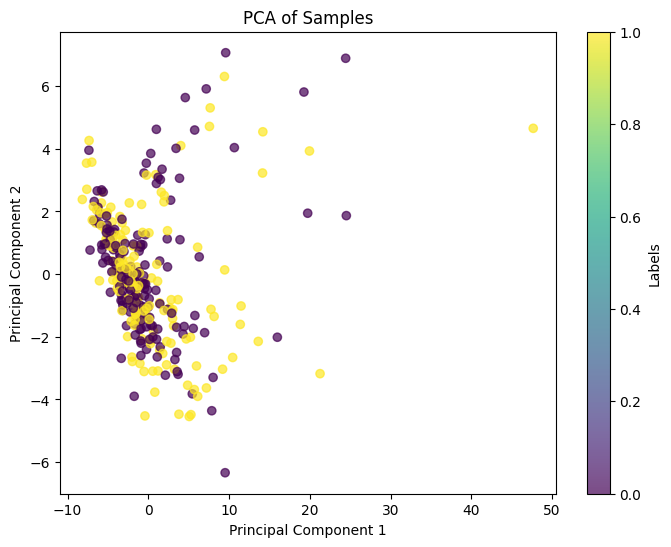

In [10]:
pca = PCA(n_components=2)

samples_pcaed = pca.fit_transform(embedding_space)


# Plot PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(samples_pcaed[:, 0], samples_pcaed[:, 1], c=labels_list, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Samples")
plt.show()

## Now we can train from the output of the model


In [11]:
predictor_model = Predictor_Model(model)


model.eval()
for i, batch in enumerate(train_clean_dl):
    X, targets, _, padding_masks, labels = batch
    # with torch.no_grad():   
    predictions, _ = predictor_model(X, padding_masks) # Feed the clean targets in - No Noise
    print(predictions)
    break

        



tensor([[0.4044]], grad_fn=<SigmoidBackward0>)


### Training for the binary prediction now: 


In [12]:
# Setup optim
lr = 1e-3
weight_decay = 1e-6
optimizer = torch.optim.AdamW(predictor_model.parameters(), lr=lr, weight_decay=weight_decay)

loss_fn = torch.nn.BCELoss()
epochs = 40

for epoch in range(epochs):
    epoch_loss = 0  # total loss of epoch
    total_active_elements = 0  # total unmasked elements in epoch

    predictor_model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for i, batch in enumerate(train_loader_tqdm):
        _, targets, _, padding_masks, labels = batch
        labels = [val.item() for val in labels]
        labels = torch.tensor(labels, dtype=torch.float32)
        labels = labels.unsqueeze(-1)

        predictions, _ = predictor_model(targets, padding_masks)

        # Cascade noise masks (batch_size, padded_length, feat_dim) and padding masks (batch_size, padded_length)
        # target_masks = target_masks * padding_masks.unsqueeze(-1)
        loss = loss_fn(predictions, labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()
        
        # Update tqdm description with current loss
        train_loader_tqdm.set_postfix(loss=loss.item())
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}  Loss: {epoch_loss}")

Epoch 1/40  Loss: 0.697252074877421


Epoch 2/40  Loss: 0.6849069992701212


Epoch 3/40  Loss: 0.6794872879981995


Epoch 4/40  Loss: 0.6744548877080282


Epoch 5/40  Loss: 0.6641682386398315


Epoch 6/40  Loss: 0.655804435412089


Epoch 7/40  Loss: 0.6416690150896708


Epoch 8/40  Loss: 0.6303681333859762


Epoch 9/40  Loss: 0.6057636737823486


Epoch 10/40  Loss: 0.5962691704432169


Epoch 11/40  Loss: 0.5662043690681458


Epoch 12/40  Loss: 0.5531806151072184


Epoch 13/40  Loss: 0.5331141153971354


Epoch 14/40  Loss: 0.5318387647469839


Epoch 15/40  Loss: 0.4781337082386017


Epoch 16/40  Loss: 0.4699900845686595


Epoch 17/40  Loss: 0.49254585305849713


Epoch 18/40  Loss: 0.4595685501893361


Epoch 19/40  Loss: 0.4581276973088582


Epoch 20/40  Loss: 0.4237107038497925


Epoch 21/40  Loss: 0.4058176974455516


Epoch 22/40  Loss: 0.38227973878383636


Epoch 23/40  Loss: 0.3948179433743159


Epoch 24/40  Loss: 0.35365862647692364


Epoch 25/40  Loss: 0.40164730449517566


Epoch 26/40  Loss: 0.3817117561896642


Epoch 27/40  Loss: 0.3301039437452952


Epoch 28/40  Loss: 0.33680536101261777


Epoch 29/40  Loss: 0.30232689281304675


Epoch 30/40  Loss: 0.3013916114966075


Epoch 31/40  Loss: 0.3246826281150182


Epoch 32/40  Loss: 0.2879011631011963


Epoch 33/40  Loss: 0.27353424578905106


Epoch 34/40  Loss: 0.27509596198797226


Epoch 35/40  Loss: 0.2274227812886238


Epoch 36/40  Loss: 0.23582619925340018


Epoch 37/40  Loss: 0.2151623231669267


Epoch 38/40  Loss: 0.3048413544893265


Epoch 39/40  Loss: 0.24384824434916177


Epoch 40/40  Loss: 0.23334651192029318


In [13]:
embedding_space = []
labels_list = []
train_clean_dl = DataLoader(
    dataset=imputation_dataset,
    shuffle=False,
    batch_size=1,
    collate_fn=lambda x: collate_unsuperv(x, max_len=max_seq_len)
)


predictor_model.eval()
for i, batch in enumerate(train_clean_dl):
    X, targets, _, padding_masks, labels = batch
    with torch.no_grad():   
        predictions, first_token = predictor_model(X, padding_masks) # Feed the clean targets in - No Noise
    # Store the meaned embedding space as an example: 
    first_token_ = first_token.squeeze().detach().numpy()
    labels = labels[0].detach().numpy()
    embedding_space.append(first_token_)
    labels_list.append(labels)


embedding_space = np.array(embedding_space)
labels_list = np.array(labels_list)
embedding_space.shape, labels_list.shape

((316, 28), (316,))

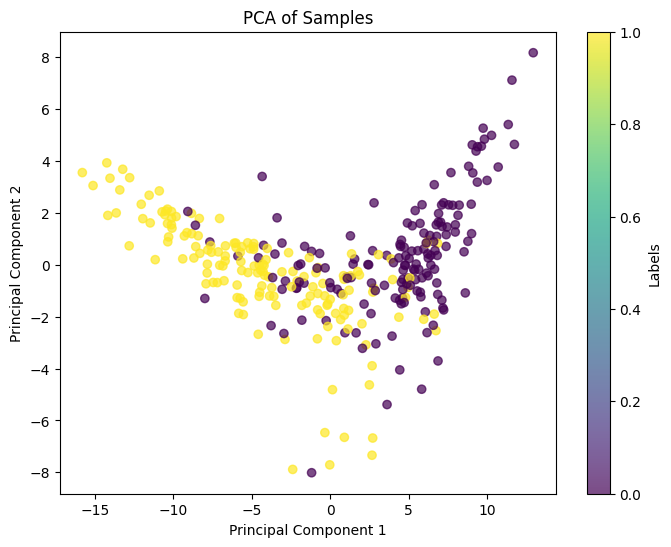

In [14]:
pca = PCA(n_components=2)

samples_pcaed = pca.fit_transform(embedding_space)


# Plot PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(samples_pcaed[:, 0], samples_pcaed[:, 1], c=labels_list, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Samples")
plt.show()